In [20]:
from matplotlib import pyplot as plt
import pandas as pd
from scipy.special import erfinv
from scipy.special import loggamma
from scipy.stats import gamma
from scipy.stats import nbinom
from scipy import special
import numpy as np
import sys
import math
import seaborn as sns
from matplotlib import colors as mcolors
from matplotlib import cm as cm
import random
from scipy.ndimage import laplace
from scipy.ndimage import gaussian_filter
from scipy.special import binom
import inspect
from scipy import stats

In [21]:
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.size'] = 14
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = [8.0,6.0]

colors = sns.color_palette("colorblind", 12)
colors1 = sns.color_palette("magma",3)
colors2 = sns.color_palette("magma",3)

# load data
data = pd.read_csv("../theory/old_files/results/spatial_integrals_dim2.csv")
data_pr = pd.read_csv("../theory/old_files/results/cleaned_data_dim2_errorFalse.csv")
data_pr = data_pr.loc[data_pr['poly_type'] == '1_1']

w_vals = data['w'].tolist()
res_vals = data_pr['residues']
pole_vals = data_pr['poles']

In [22]:
# old functions

## functions

# def finite_sfs_k(n,k,sigma,s,sigma_vals,pole_vals,res_vals,mu=1e-7,N=100,D=1,d=2):
#     beta = rate_p(sigma,s,sigma_vals,pole_vals,N,D,d)
#     alpha = shape_p(sigma,s,sigma_vals,res_vals,mu,N,D,d)
#     logval = k*np.log(n)+alpha*np.log(beta)-(k+alpha)*np.log(n+beta)+loggamma(k+alpha)-loggamma(k+1)-loggamma(alpha)
#     return(np.e**logval)

def power(zs, sigma, s, sigma_vals, res_vals, pole_vals, Nval=10000):
    beta = rate_p(sigma,s,sigma_vals,pole_vals,N=Nval)
    alpha = shape_p(sigma,s,sigma_vals,res_vals,N=Nval)
    #return(1-gamma.cdf(zs,a=alpha,scale=1/beta))
    return(gamma.sf(zs,a=alpha,scale=1/beta))

def calc_V_G(sigma,kappa_list,sigma_vals,s,beta,L=1e6,mu=1e-8,d=2,D=1,N=10000):
    f = interp1d(sigma_vals,kappa_list,fill_value="extrapolate")
    kappa_val = f(sigma)
    VG_val = (2*L*mu*kappa_val*(beta**2))/(s**2*(np.sqrt(D/s)**d)*N)
    return VG_val

def calc_V_E(sigma,sigma2R,sigma2G,l=1,d=2):
    coef=1-1/((1+2*(sigma/l)**2)**(d/2))
    return(sigma2R+coef*sigma2G)

def get_zs(s,beta,Vp,n,a=1e-8):
    vs = 2*erfinv(1-a)**2
    return(0.5 - (0.5)*math.sqrt(1-(2*vs*(Vp/n))/((beta)**2)))

def power_all(sigma,s,sigma_vals,kappa_list,
              res_vals,pole_vals,
              sigma2R=0.5,sigma2G=0.5,Nval=10000,n=1e6,a=1e-8,L=1e6,mu=1e-8,d=2,D=1,l=1,beta=1.0):
    lc = np.sqrt(D/s)
    Vg=calc_V_G(sigma/lc,kappa_list,sigma_vals,s,beta,N=Nval,L=L,mu=mu,d=d,D=D)#[sigma_vals.index(sigma)]
    Ve=calc_V_E(sigma/lc,sigma2R,sigma2G,l,d)
    Vp=Vg+Ve
    zs=get_zs(s,beta,Vp=Vp,n=n,a=a)
    power_val = power(zs,sigma,s,sigma_vals,res_vals,pole_vals,Nval)
    return(power_val)

def burden_ncp(s,sigma,sigma_vals,pole_vals,res_vals,
               gamma=2,prop_cases=0.5,num_snps=100,num_assoc=100,N=1000,D=1,d=2,mu=1e-8,n=1e6):
    # add later - num_assoc<=num_snps check
    # get rate and shape params
    rate = rate_p(sigma,s,sigma_vals,pole_vals,N=N,D=D,d=d)
    shape = shape_p(sigma,s,sigma_vals,res_vals,mu=mu,N=N,D=D,d=d)
    # calc mean and variance
    r = shape
    p = rate/(rate+n)
    # return ncp
    num_cases = math.floor(prop_cases*n) # round to integer
    num_controls = n-num_cases
    mean = r*(1-p)/p
    var = r*(1-p)/(p**2)#mean/p
    ncp = np.sqrt((2*num_cases*num_controls)/(num_cases+num_controls))*(num_assoc/np.sqrt(num_snps))*(mean/(np.sqrt(var+mean-mean**2)))*(gamma-1)
    return ncp

def power_from_ncp(ncp,alpha,df=1):
    power = 1 - stats.ncx2.cdf(stats.chi2.ppf(1 - alpha, df=1), df=1, nc=ncp)
    return power

def power_all_burden(sigma,s,sigma_vals,
              res_vals,pole_vals,gamma=2,prop_cases=0.1,num_snps=100,num_assoc=100,
             N=10000,n=1e4,mu=1e-8,d=2,D=1,alpha=5e-8,df=1):
    ncp_temp = burden_ncp(s,sigma,sigma_vals,pole_vals,res_vals,gamma=gamma,prop_cases=prop_cases,
                         num_snps=num_snps,num_assoc=num_assoc,N=N,n=n,mu=mu,d=d,D=D)
    power_temp = power_from_ncp(ncp_temp,alpha,df)
    return power_temp

In [23]:
def poles(w,w_vals,pole_vals):
    f=interp1d(w_vals,pole_vals,fill_value="extrapolate")
    return(f(w))

def residues(w,w_vals, res_vals):
    res_vals=[-1*x for x in res_vals]
    f = interp1d(w_vals,res_vals,fill_value="extrapolate")
    return (f(w))
def get_gammae(w,s,w_vals,pole_vals,N=10000,D=1,d=1):
    l_c=np.sqrt(D/s)
    return(s*N*(l_c**d)*poles(w/l_c,w_vals,pole_vals))

def get_thetae(w,s,w_vals,res_vals,mu=1e-8,N=10000,D=1,d=1):
    l_c = np.sqrt(D / s)
    return(mu*N*(l_c**d)*residues(w/l_c,w_vals,res_vals))

def get_vg(beta,L,n,omega,s,omega_vals,pole_vals,res_vals,mu=1e-8,N=100,D=1,d=2):
    # function to calculate genetic variance
    gamma = get_gammae(omega,s,omega_vals,pole_vals,N,D,d)
    theta = get_thetae(omega,s,omega_vals,res_vals,mu,N,D,d)
    var_x = theta*(gamma+n)/(n*gamma**2)
    return var_x*(beta**2)*L
    
def finite_sfs_k(n,k,w,s,w_vals,pole_vals,res_vals,mu=1e-7,N=100,D=1,d=2):
    gammae = get_gammae(w,s,w_vals,pole_vals,N,D,d)
    thetae = get_thetae(w,s,w_vals,res_vals,mu,N,D,d)
    logval = k*np.log(n)+thetae*np.log(gammae)-(k+thetae)*np.log(n+gammae)+loggamma(k+thetae)-loggamma(k+1)-loggamma(thetae)
    return(np.e**logval)

def get_etaell(beta,L,n,omega,s,omega_vals,pole_vals,res_vals,mu=1e-8,N=100,D=1,d=2,Ve=0.1):
    # function to calculate GWAS power
    gamma = get_gammae(omega,s,omega_vals,pole_vals,N,D,d)
    theta = get_thetae(omega,s,omega_vals,res_vals,mu,N,D,d)
#     Vg = get_vg(beta,L,n,omega,s,omega_vals,pole_vals,res_vals)
    Vp = 1#Vg+Ve
    xstar = get_zs(s,beta,Vp,n,a=1e-8)
    upper_lim = math.floor(n*xstar)
    sum_total = 0
    for i in range(upper_lim+1):
        sum_total+=finite_sfs_k(n,i,omega,s,omega_vals,pole_vals,res_vals)
    return 1 - sum_total

def burden_ncp(s,omega,omega_vals,pole_vals,res_vals,
               gamma=2,prop_cases=0.5,num_snps=100,num_assoc=100,N=1000,D=1,d=2,mu=1e-8,n=1e6):
    # add later - num_assoc<=num_snps check
    # get rate and shape params
    rate = get_gammae(omega,s,omega_vals,pole_vals,N=N,D=D,d=d)
    shape = get_thetae(omega,s,omega_vals,res_vals,mu=mu,N=N,D=D,d=d)
    # calc mean and variance
    r = shape
    p = rate/(rate+n)
    # return ncp
    num_cases = math.floor(prop_cases*n) # round to integer
    num_controls = n-num_cases
    mean = r*(1-p)/p
    var = r*(1-p)/(p**2)#mean/p
    ncp = np.sqrt((2*num_cases*num_controls)/(num_cases+num_controls))*(num_assoc/np.sqrt(num_snps))*(mean/(np.sqrt(var+mean-mean**2)))*(gamma-1)
    return ncp

def power_from_ncp(ncp,alpha,df=1):
    power = 1 - stats.ncx2.cdf(stats.chi2.ppf(1 - alpha, df=1), df=1, nc=ncp)
    return power

def power_all_burden(omega,s,omega_vals,
              res_vals,pole_vals,gamma=2,prop_cases=0.1,num_snps=100,num_assoc=100,
             N=10000,n=1e4,mu=1e-8,d=2,D=1,alpha=5e-8,df=1):
    ncp_temp = burden_ncp(s,omega,omega_vals,pole_vals,res_vals,gamma=gamma,prop_cases=prop_cases,
                         num_snps=num_snps,num_assoc=num_assoc,N=N,n=n,mu=mu,d=d,D=D)
    power_temp = power_from_ncp(ncp_temp,alpha,df)
    return power_temp

# def get_lambda():
    # function to calculate burden test NCP
    
# def get_powburden():
    # function to calculate burden test power

<ipython-input-24-5b278e890068>:83: RuntimeWarning: divide by zero encountered in double_scalars
  axs[1][1].loglog(b_list_2,[get_etaell(b_temp,L,n,w1,s2,w_vals,pole_vals,res_vals,Ve=0.5)/get_etaell(b_temp,L,n,w2,s2,w_vals,pole_vals,res_vals,Ve=0.5) for b_temp in b_list_2],


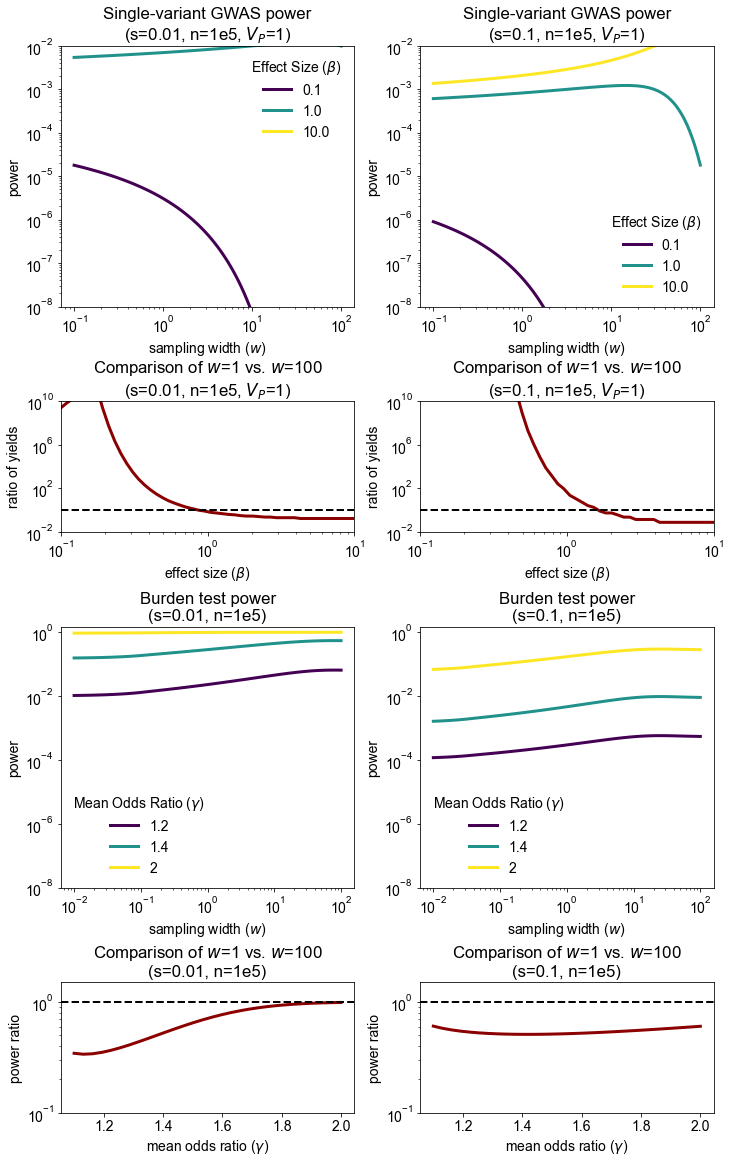

In [24]:
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
from matplotlib import gridspec
from scipy.interpolate import interp1d
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.size'] = 14
# fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(8, 10))
fig = plt.figure(figsize=(10, 16))
gs = gridspec.GridSpec(4, 2, height_ratios=[2, 1, 2,1 ])  

# Assign the axes based on the GridSpec
axs = [
    [fig.add_subplot(gs[0, j]) for j in range(2)],
    [fig.add_subplot(gs[1, j]) for j in range(2)],
    [fig.add_subplot(gs[2, j]) for j in range(2)],
    [fig.add_subplot(gs[3, j]) for j in range(2)]
]


num_b=3

b_list = np.logspace(-1,1,num_b)
colors = plt.cm.viridis(np.linspace(0,1,num_b))
# colors2 = plt.cm.magma(np.linspace(0,1,num_b))
w_range = np.logspace(-1,2,100)

L = 1000
n = 100000
s1 = 0.01
s2 = 0.1

w1 = 1
w2 = 100

# top left

for i in range(num_b):
    axs[0][0].loglog(w_range,[get_etaell(b_list[i],L,n,w,s1,w_vals,pole_vals,res_vals,Ve=0.5) for w in w_range],color=colors[i],label=str(round(b_list[i],2)))

# colormap = plt.cm.viridis
# norm = mpl.colors.LogNorm(vmin=min(b_list), vmax=max(b_list))
# cbar1 = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=colormap), ax=axs[0][0])
# cbar1.set_label(r'effect size ($\beta$)')
axs[0][0].legend(title=r"Effect Size ($\beta$)",frameon=False,title_fontsize=14)
axs[0][0].set_xlabel(r"sampling width ($w$)")
axs[0][0].set_ylabel("power")
axs[0][0].set_title("Single-variant GWAS power\n(s="+str(s1)+r", n=1e5, $V_P$=1)")
axs[0][0].set_ylim(1e-8,1e-2)
    
# top right

for i in range(num_b):
    axs[0][1].loglog(w_range,[get_etaell(b_list[i],L,n,w,s2,w_vals,pole_vals,res_vals,Ve=0.5) for w in w_range],color=colors[i],label=str(round(b_list[i],2)))

# colormap = plt.cm.viridis
# norm = mpl.colors.LogNorm(vmin=min(b_list), vmax=max(b_list))
# cbar1 = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=colormap), ax=axs[0][1])
# cbar1.set_label(r'effect size ($\beta$)')
axs[0][1].legend(title=r"Effect Size ($\beta$)",frameon=False,title_fontsize=14)
axs[0][1].set_xlabel(r"sampling width ($w$)")
axs[0][1].set_ylabel("power")
axs[0][1].set_title("Single-variant GWAS power\n(s="+str(s2)+r", n=1e5, $V_P$=1)")
axs[0][1].set_ylim(1e-8,1e-2)
    
# 2nd row left

b_list_2 = np.logspace(-1,1,50)
axs[1][0].loglog(b_list_2,[get_etaell(b_temp,L,n,w1,s1,w_vals,pole_vals,res_vals,Ve=0.5)/get_etaell(b_temp,L,n,w2,s1,w_vals,pole_vals,res_vals,Ve=0.5) for b_temp in b_list_2],
                color='darkred')
# axs[1,0].loglog(b_list,[get_etaell(b_temp,L,n,w1,s1,omega_vals,pole_vals,res_vals,Ve=0.5) for b_temp in b_list])
# axs[1,0].loglog(b_list,[get_etaell(b_temp,L,n,w2,s1,omega_vals,pole_vals,res_vals,Ve=0.5) for b_temp in b_list])
axs[1][0].axhline(y=1, color='black', linestyle='--',linewidth=2)
axs[1][0].set_ylim(1e-2,1e10)
axs[1][0].set_xlim(1e-1,1e1)
locator = LogLocator(numticks=2)
# axs[1,0].xaxis.set_major_locator(locator)
axs[1][0].set_xlabel(r"effect size ($\beta$)")
axs[1][0].set_ylabel("ratio of yields")# of yields (narrow/broad)")
axs[1][0].set_title("Comparison of $w$="+str(w1)+r" vs. $w$="+str(w2)+"\n(s="+str(s1)+r", n=1e5, $V_P$=1)")

# 2nd row right

axs[1][1].loglog(b_list_2,[get_etaell(b_temp,L,n,w1,s2,w_vals,pole_vals,res_vals,Ve=0.5)/get_etaell(b_temp,L,n,w2,s2,w_vals,pole_vals,res_vals,Ve=0.5) for b_temp in b_list_2],
                color='darkred')
# axs[1,1].loglog(b_list,[get_etaell(b_temp,L,n,w1,s2,omega_vals,pole_vals,res_vals,Ve=0.5) for b_temp in b_list])
# axs[1,1].loglog(b_list,[get_etaell(b_temp,L,n,w2,s2,omega_vals,pole_vals,res_vals,Ve=0.5) for b_temp in b_list])
axs[1][1].axhline(y=1, color='black', linestyle='--',linewidth=2)  
axs[1][1].set_ylim(1e-2,1e10)
axs[1][1].set_xlim(1e-1,1e1)
# axs[1,1].xaxis.set_major_locator(locator)
axs[1][1].set_xlabel(r"effect size ($\beta$)")
axs[1][1].set_ylabel("ratio of yields")# of yields (narrow/broad)")
axs[1][1].set_title("Comparison of $w$="+str(w1)+r" vs. $w$="+str(w2)+"\n(s="+str(s2)+r", n=1e5, $V_P$=1)")
# axs[1][1].set_title("Ratio of yields, s="+str(s2))

# 3rd row left

ccratio=1e-3
# g_list = np.logspace(0,1,num_b)
g_list = [1.2,1.4,2]
g_list_2 = np.linspace(1.1,2,30)
# colors2 = plt.cm.plasma(np.linspace(0, 1, num_b))

for i in range(num_b):
    axs[2][0].loglog(w_vals,[power_all_burden(w, s1, w_vals, res_vals, pole_vals, prop_cases=ccratio, gamma=g_list[i],n=n,num_snps=L,num_assoc=L)
                for w in w_vals],color=colors[i],label=str(round(g_list[i],2)))
# norm2 = mpl.colors.LogNorm(vmin=min(g_list), vmax=max(g_list))
# colormap2 = plt.cm.magma
# cbar2 = fig.colorbar(mpl.cm.ScalarMappable(norm=norm2, cmap=colormap2), ax=axs[2][0])
# cbar2.set_label(r'mean OR ($\gamma$)')
axs[2][0].set_xlabel(r"sampling width ($w$)")
axs[2][0].set_ylabel(r"power")
axs[2][0].set_title("Burden test power\n(s="+str(s1)+", n=1e5)")
axs[2][0].set_ylim(1e-8,1.5)
axs[2][0].legend(title=r"Mean Odds Ratio ($\gamma$)",frameon=False,title_fontsize=14)

# 3rd row right

# ccratio=1e-3
# # g_list = np.linspace(1,5,30)
# colors = plt.cm.magma(np.linspace(0, 1, 30))

for i in range(num_b):
    axs[2][1].loglog(w_vals,[power_all_burden(w, s2, w_vals, res_vals, pole_vals, prop_cases=ccratio, gamma=g_list[i],n=n,num_snps=L,num_assoc=L)
                for w in w_vals],color=colors[i],label=str(round(g_list[i],2)))
# norm = mpl.colors.LogNorm(vmin=min(g_list), vmax=max(g_list))
# colormap = plt.cm.magma
# cbar2 = fig.colorbar(mpl.cm.ScalarMappable(norm=norm2, cmap=colormap2), ax=axs[2][1])
# cbar2.set_label(r'mean OR ($\gamma$)')
axs[2][1].legend(title=r"Mean Odds Ratio ($\gamma$)",frameon=False,title_fontsize=14)
axs[2][1].set_xlabel(r"sampling width ($w$)")
axs[2][1].set_ylabel(r"power")
axs[2][1].set_title("Burden test power\n(s="+str(s2)+", n=1e5)")
axs[2][1].set_ylim(1e-8,1.5)    
   
    
# bottom left
axs[3][0].plot(g_list_2,[power_all_burden(w1, s1, w_vals, res_vals, pole_vals, prop_cases=ccratio, gamma=gt,n=n,num_snps=L,num_assoc=L)/
                           power_all_burden(w2, s1, w_vals, res_vals, pole_vals, prop_cases=ccratio, gamma=gt,n=n,num_snps=L,num_assoc=L) for gt in g_list_2],
              color='darkred')
axs[3][0].set_yscale('log')
axs[3][0].axhline(y=1, color='black', linestyle='--',linewidth=2)
axs[3][0].set_ylim(1e-1,1.5)
axs[3][0].set_title("Comparison of $w$="+str(w1)+r" vs. $w$="+str(w2)+"\n(s="+str(s1)+r", n=1e5)")
axs[3][0].set_ylabel("power ratio")
axs[3][0].set_xlabel(r"mean odds ratio ($\gamma$)")

# bottom right
axs[3][1].plot(g_list_2,[power_all_burden(w1, s2, w_vals, res_vals, pole_vals, prop_cases=ccratio, gamma=gt,n=n,num_snps=L,num_assoc=L)/
                           power_all_burden(w2, s2, w_vals, res_vals, pole_vals, prop_cases=ccratio, gamma=gt,n=n,num_snps=L,num_assoc=L) for gt in g_list_2],
              color='darkred')
axs[3][1].set_yscale('log')
axs[3][1].axhline(y=1, color='black', linestyle='--',linewidth=2)
axs[3][1].set_ylim(1e-1,1.5)
axs[3][1].set_title("Comparison of $w$="+str(w1)+r" vs. $w$="+str(w2)+"\n(s="+str(s2)+r", n=1e5)")
axs[3][1].set_ylabel("power ratio")
axs[3][1].set_xlabel(r"mean odds ratio ($\gamma$)")


plt.tight_layout(pad=0.1)
plt.savefig("power_fig_ashg.pdf")


# plt.show()
#